In [31]:
import tensorflow as tf
# from utils import vis, load_batch#, load_data
from utils import load_complete_data, show_batch_images
from model import DCGAN, dist_train_step#, train_step
from tqdm import tqdm
import os
import shutil
import pickle
from glob import glob
from natsort import natsorted
import wandb
import numpy as np
import cv2
from lstm_kmean.model import TripleNet
import math
import sys

import warnings

In [3]:
def filter_tfa_warning(message, category, filename, lineno, file=None, line=None):
    return not ("tfa_eol_msg.py" in filename and issubclass(category, UserWarning))

warnings.filterwarnings(action="ignore", module=".*tfa_eol_msg.*", category=UserWarning)
warnings.showwarning = filter_tfa_warning

In [4]:
tf.random.set_seed(45)
np.random.seed(45)

clstoidx = {}
idxtocls = {}

for idx, item in enumerate(natsorted(glob('data/images/test/*')), start=0):
	clsname = os.path.basename(item)
	clstoidx[clsname] = idx
	idxtocls[idx] = clsname

image_paths = natsorted(glob('data/images/test/*/*'))
imgdict     = {}
for path in image_paths:
	key = path.split(os.path.sep)[-2]
	if key in imgdict:
		imgdict[key].append(path)
	else:
		imgdict[key] = [path]

In [5]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '1'

In [7]:
n_channels  = 14
n_feat      = 128
batch_size  = 128
test_batch_size  = 1
n_classes   = 10

# data_cls = natsorted(glob('data/thoughtviz_eeg_data/*'))
# cls2idx  = {key.split(os.path.sep)[-1]:idx for idx, key in enumerate(data_cls, start=0)}
# idx2cls  = {value:key for key, value in cls2idx.items()}

with open('C:/Users/devan/Documents/pythonPractice/EEG2Imagedata/eeg/image/data.pkl', 'rb') as file:
    data = pickle.load(file, encoding='latin1')
    train_X = data['x_train']
    train_Y = data['y_train']
    test_X = data['x_test']
    test_Y = data['y_test']

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/devan/Documents/pythonPractice/EEG2Imagedata/eeg/image/data.pkl'

In [ ]:
import pandas as pd

for i in range(5000):
    df = pd.DataFrame(train_X[i].squeeze())
    df.to_csv(f"C:/Users/devan/Documents/pythonPractice/EEG2Image/data/misc_eeg/{i}_csv.csv")
    np.save(f"C:/Users/devan/Documents/pythonPractice/EEG2Image/data/misc_eeg/{i}", np.array(train_X[i]))

In [ ]:
test_path = []
for X, Y in zip(test_X, test_Y):
	test_path.append(np.random.choice(imgdict[idxtocls[np.argmax(Y)]], size=(1,) ,replace=True)[0])

In [ ]:
test_batch  = load_complete_data(test_X, test_Y, test_path, batch_size=test_batch_size)
X, Y, I      = next(iter(test_batch))
# latent_label = Y[:16]

In [8]:
gpus = tf.config.list_physical_devices('GPU')
mirrored_strategy = tf.distribute.MirroredStrategy(devices=['/GPU:1'], 
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
n_gpus = mirrored_strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1',)


In [9]:
latent_dim = 128
input_res  = 128

In [10]:
triplenet = TripleNet(n_classes=n_classes)
opt     = tf.keras.optimizers.Adam(learning_rate=3e-4)
triplenet_ckpt    = tf.train.Checkpoint(step=tf.Variable(1), model=triplenet, optimizer=opt)
triplenet_ckptman = tf.train.CheckpointManager(triplenet_ckpt, directory='lstm_kmean/experiments/best_ckpt', max_to_keep=5000)
triplenet_ckpt.restore(triplenet_ckptman.latest_checkpoint)
print('TripletNet restored from the latest checkpoint: {}'.format(triplenet_ckpt.step.numpy()))
_, latent_Y = triplenet(X, training=False)

TripletNet restored from the latest checkpoint: 430761


NameError: name 'X' is not defined

In [254]:
print('Extracting test eeg features:')
# test_eeg_features = np.array([np.squeeze(triplenet(E, training=False)[1].numpy()) for E, Y, X in tqdm(test_batch)])
# test_eeg_y        = np.array([Y.numpy()[0] for E, Y, X in tqdm(test_batch)])
test_image_count = 5000 #// n_classes
# test_labels = np.tile(np.expand_dims(np.arange(0, 10), axis=-1), [1, test_image_count//n_classes])
# test_labels = np.sort(test_labels.ravel())

test_eeg_cls      = {}
test_eeg_cls_orig = {}
for E, Y, X in tqdm(test_batch):
    break
    Y = Y.numpy()[0]
    if Y not in test_eeg_cls:
        # print(E.shape)
        test_eeg_cls[Y] = [np.squeeze(triplenet(E, training=False)[1].numpy())]
    else:
        test_eeg_cls[Y].append(np.squeeze(triplenet(E, training=False)[1].numpy()))


Extracting test eeg features:


  0%|                                                                                         | 0/5706 [00:00<?, ?it/s]

(1, 32, 14)
tf.Tensor(
[[[0.88043356 0.8909298  0.8742727  0.88910437 0.8820308  0.9037079
   0.89754707 0.89503706 0.98790646 0.8893326  0.8760981  0.88271534
   0.8833999  0.8776954 ]
  [0.88157445 0.87929267 0.8776954  0.88522536 0.8854535  0.90690243
   0.90576154 0.90028524 0.99132913 0.88864803 0.8776954  0.8833999
   0.8808899  0.88157445]
  [0.8829435  0.887279   0.8806617  0.88841987 0.88385624 0.9041643
   0.8984598  0.8959498  0.9917855  0.8893326  0.8820308  0.8818026
   0.8856817  0.8824872 ]
  [0.8831717  0.8879635  0.88111806 0.88841987 0.8849971  0.9041643
   0.9021107  0.89663434 0.993611   0.8897889  0.882259   0.8820308
   0.8868226  0.8840844 ]
  [0.88271534 0.8806617  0.8845408  0.8865944  0.88476896 0.90462065
   0.9053052  0.9021107  0.9952082  0.8900171  0.8820308  0.8840844
   0.8849971  0.88636625]
  [0.88636625 0.8934398  0.88705075 0.89321166 0.882259   0.90347975
   0.8964062  0.8996007  0.9954364  0.8904735  0.88590986 0.8840844
   0.88956076 0.887279  ]
 

In [37]:
for _ in range(n_classes):
	test_eeg_cls[_] = np.array(test_eeg_cls[_])

In [38]:
for cl in range(n_classes):
	N = test_eeg_cls[cl].shape[0]
	per_cls_image = int(math.ceil((test_image_count//n_classes) / N))
	test_eeg_cls[cl] = np.expand_dims(test_eeg_cls[cl], axis=1)
	test_eeg_cls[cl] = np.tile(test_eeg_cls[cl], [1, per_cls_image, 1])
	test_eeg_cls[cl] = np.reshape(test_eeg_cls[cl], [-1, latent_dim])

In [75]:
lr = 3e-4
with mirrored_strategy.scope():
    model        = DCGAN()
    model_gopt   = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.2, beta_2=0.5)
    model_copt   = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.2, beta_2=0.5)
    ckpt         = tf.train.Checkpoint(step=tf.Variable(1), model=model, gopt=model_gopt, copt=model_copt)
    ckpt_manager = tf.train.CheckpointManager(ckpt, directory='experiments/best_ckpt', max_to_keep=300)
    ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()

In [76]:
START         = int(ckpt.step.numpy())

In [77]:
if ckpt_manager.latest_checkpoint:
	print('Restored from last checkpoint epoch: {0}'.format(START))

Restored from last checkpoint epoch: 74551


In [347]:
for cl in range(1,2):
    # print("Reached " + str(cl))
    test_noise  = np.random.uniform(size=(test_eeg_cls[cl].shape[0],128), low=-1, high=1)
    noise_lst   = np.concatenate([test_noise, test_eeg_cls[cl]], axis=-1)

    save_path = 'experiments/finalversion/{}/{}'.format(212, cl)
    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    for idx, noise in enumerate(tqdm(noise_lst)):
        np.save(save_path + '/{}_{}_eeg'.format(cl, idx), noise)
        X = mirrored_strategy.run(model.gen, args=(tf.expand_dims(noise, axis=0),))
        X = cv2.cvtColor(tf.squeeze(X).numpy(), cv2.COLOR_RGB2BGR)
        X = np.uint8(np.clip((X*0.5 + 0.5)*255.0, 0, 255))
        cv2.imwrite(save_path+'/{}_{}.jpg'.format(cl, idx), X)

  0%|                                                                                          | 0/575 [00:00<?, ?it/s]

(256,)


In [23]:
pip uninstall transformers

^C
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to c:\users\devan\appdata\local\temp\pip-req-build-mj1j1xf6
  Resolved https://github.com/huggingface/transformers.git to commit 093848d3ccf3884caf048718b6bae833da0edb94
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for transformers: filename=transformers-4.35.0.dev0-py3-none-any.whl size=7817896 sha256=a7834d564b8e81961e3f4f0051510dd104453198363ff91fee2b77da26c04cc7
  Stored in directory: C:\Users\devan\AppData\Local\Temp\pip-ephem-wheel-cache-dhcujjzd\wheels\cf\59\82\6492402e887a68975030bf8c06532260abc16abb7ccd8127cc
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installati

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git 'C:\Users\devan\AppData\Local\Temp\pip-req-build-mj1j1xf6'
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 0.8.0 requires torch<1.14,>=1.9, which is not installed.
autogluon-multimodal 0.8.0 requires pytorch-lightning<1.10.0,>=1.9.0, but you have pytorch-lightning 1.7.7 which is incompatible.
autogluon-multimodal 0.8.0 requires transformers<4.27.0,>=4.23.0, but yo

In [29]:
pip install tensorflow

  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.1.0
    Uninstalling google-auth-oauthlib-1.1.0:
      Successfully uninstalled google-auth-oauthlib-1.1.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.0
    Uninstalling tensorboard-2.15.0:
      Successfully uninstalled tensorboard-2.15.0
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 0.8.0 requires torch<1.14,>=1.9, which is not installed.
pytorch-lightning 1.7.7 requires torch>=1.9.*, which is not installed.
autogluon-multimodal 0.8.0 requires pytorch-lightning<1.10.0,>=1.9.0, but you have pytorch-lightning 1.7.7 which is incompatible.
autogluon-multimodal 0.8.0 requires tensorboard<3,>=2.9, but you have tensorboard 2.8.0 which is incompatible.
autogluon-multimodal 0.8.0 requires transformers<4.2

In [41]:
import requests
from  PIL import Image
from transformers import  BlipProcessor, BlipForConditionalGeneration
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model2 = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")


ImportError: cannot import name 'BlipProcessor' from 'transformers' (C:\Users\devan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\__init__.py)

In [40]:
pip install accelerate latest

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   ---------------------------------------- 0.6/192.3 MB 12.2 MB/s eta 0:00:16
   ---------------------------------------- 1.6/192.3 MB 19.8 MB/s eta 0:00:10
    --------------------------------------- 2.5/192.3 MB 22.5 MB/s eta 0:00:09
    --------------------------------------- 3.4/192.3 MB 22.0 MB/s eta 0:00:09
    --------------------------------------- 4.5/192.3 MB 23.8 MB/s eta 0:00:08
   - -------------------------------------- 5.4/192.3 MB 24.9 MB/s eta 0:00:08
   - -------------------------------------- 6.3/192.3 MB 23.9 MB/s eta 0:00:08
   - -------------------------------------- 7.4/192.3 MB 24.8 MB/s eta 0:00:08
   - -------------------------------------- 8.4/192.3 MB 25.6 MB/s eta 0:00:08
   - -------------------------------------- 9.3/192.3 MB 25.9 MB/s eta 0:00:08
   -- -------------------------------

DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 0.8.0 requires pytorch-lightning<1.10.0,>=1.9.0, but you have pytorch-lightning 1.7.7 which is incompatible.
autogluon-multimodal 0.8.0 requires tensorboard<3,>=2.9, but you have tensorboard 2.8.0 which is incompatible.
autogluon-multimodal 0.8.0 requires torch<1.14,>=1.9, but you have torch 2.1.0 which is incompatible.
autogluon-multimodal 0.8.0 requires transformers<4.27.0,>=4.23.0, but you have transformers 4.35.0.

In [27]:
def image_to_text(path = "C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered/apple/0_35.jpg"):
    text = "a photograph of "
    image = Image.open(path)
    inputs = processor(image,text, return_tensors = "pt")

    out = model2.generate(**inputs)
    return (processor.decode(out[0], skip_special_tokens=True))

In [183]:
import os
import random
import colorsys
idx_to_name = {1: "apple", 2: "blue car", 3: "dog", 4: "flower", 5: "gold bracelet", 6: "phone", 7: "scooter", 8: "tiger", 9: "wallet", 10: "watches"}
name_to_idx = {j:i for (i,j) in idx_to_name.items()}
path = "C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered"
direc = os.listdir(path)
rel_files = {}
for name in direc:
    true_img_path = path + f'/{name}/true_image.jpg'
    rel_files[name] = list(filter(lambda x: x[-4:] == ".jpg", os.listdir(path + f'/{name}')))
    
    
    
def pick_image(idx = 1):
    img_name = random.choice(rel_files[idx_to_name[idx]])[:-4]
    eeg_name = img_name + "_eeg"
    desc_name  = img_name + "_desc" 
    img_path =  path + f"/{idx_to_name[idx]}/" + img_name + ".jpg"
    eeg_path = path + f"/{idx_to_name[idx]}/" + eeg_name + ".npy"
    desc_path = path + f"/{idx_to_name[idx]}/" + desc_name + ".txt"
    
    return img_path, eeg_path, desc_path

import base64
from io import BytesIO

def PIL_to_encode(image):
    
    if image.mode == 'RGBA':
        # Convert the image into RGB
        rgb_image = Image.new("RGB", image.size, (255, 255, 255))  # White background
        rgb_image.paste(image, mask=image.split()[3])  # Paste the image using the alpha channel as a mask
        image = rgb_image
    
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    return img_str

def get_images(idx):
    data = {}
    im_path, embed_path, desc_path = pick_image(idx)
    print(im_path, embed_path, desc_path)
    embed_img = visualize_embed(embed_path)
    eeg_image = eeg_vis()
    gen_img = Image.open(im_path)
    text_desc = ""
    with open(desc_path, "r") as f:
        text_desc = f.read()
    data["gen_img"] = PIL_to_encode(gen_img).decode()
    data["eeg_img"] = PIL_to_encode(eeg_image).decode()
    data["embed_img"] = PIL_to_encode(embed_img).decode()
    data["desc"] = text_desc
    return data 
get_images(1)
    

C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered/apple/0_79_eeg.npy


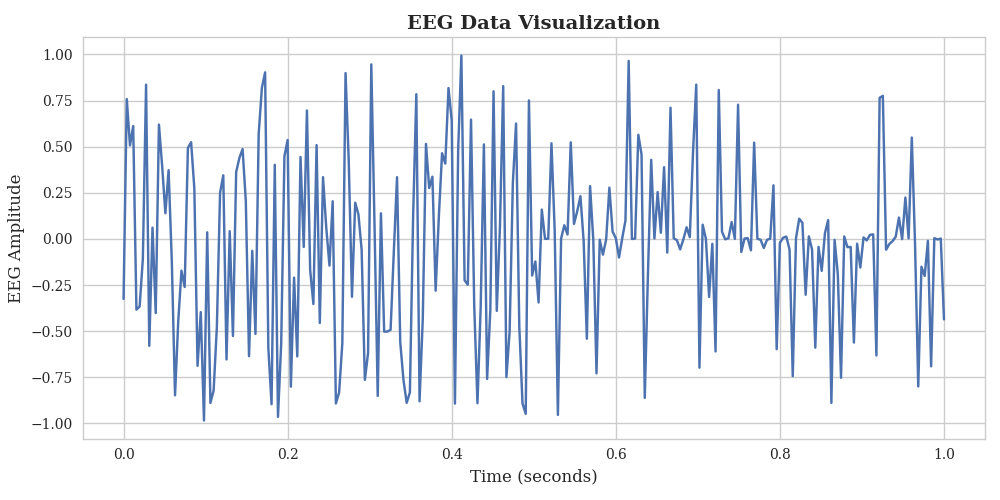

In [406]:
def visualize_embed(file_path = None, eeg_data = None):
    buf = io.BytesIO() 
    # Load the data
    print(file_path)
    if type(eeg_data) == type(None): 
        eeg_data = np.load(file_path)
    # Time vector (assuming a common EEG sampling rate of 256 Hz)
    time = np.linspace(0, len(eeg_data) / 256, len(eeg_data))
    
    # Set font properties for a more formal appearance
    font_properties = {
        'family': 'serif',
        'weight': 'normal',
        'size': 12
    }

    # Plotting the EEG data with updated font properties
    plt.figure(figsize=(10, 5))
    plt.plot(time, eeg_data)
    plt.xlabel('Time (seconds)', fontdict=font_properties)
    plt.ylabel('EEG Amplitude', fontdict=font_properties)
    plt.title('EEG Data Visualization', fontdict={'family': 'serif', 'weight': 'bold', 'size': 14})
    plt.grid(True)
    plt.tight_layout()

    # Update tick labels font
    plt.xticks(fontname='serif')
    plt.yticks(fontname='serif')

    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    img = Image.open(buf)
    return img

# Test the function with the provided EEG data file
visualize_embed("C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered/apple/0_79_eeg.npy")


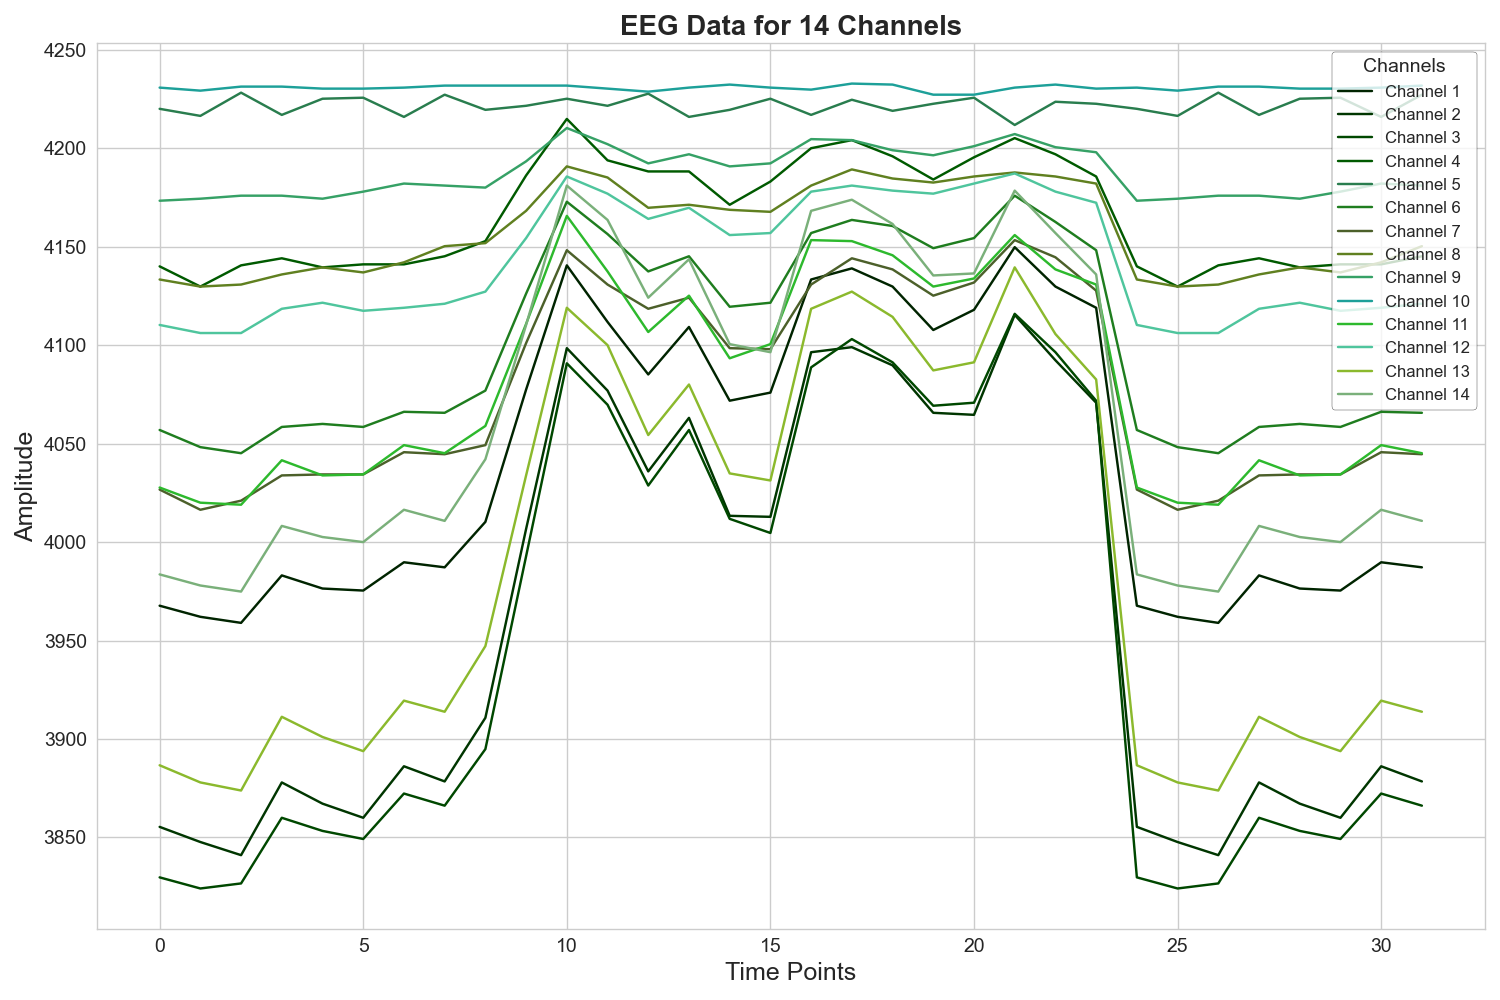

In [235]:
import matplotlib.pyplot as plt
import io

def eeg_vis(r = -1):
    buf = io.BytesIO() 
    plt.rcParams["font.family"] = "Times New Roman"
    if r == -1:
        r = random.choice(range(45000))
    eeg_data = np.load(f'C:/Users/devan/Documents/pythonPractice/EEG2Image/data/misc_eeg/{r}.npy')
    plt.figure(figsize=(15, 10))
    plt.style.use('seaborn-whitegrid')
    # Shades of green
    green_shades = green_shades = ['#002800','#003C00','#005000','#006400', '#2E8B57', '#228B22', '#556B2F', '#6B8E23', '#3CB371', '#20B2AA', '#32CD32', '#66CDAA', '#9ACD32', '#8FBC8F']
    def darken_color(rgb_color, factor=0.9):
        r, g, b = rgb_color
        h, l, s = colorsys.rgb_to_hls(r / 255.0, g / 255.0, b / 255.0)
        l = max(0, min(1, l * factor))
        r, g, b = colorsys.hls_to_rgb(h, l, s)
        return r, g, b
    # Convert hex to RGB and then darken the color
    green_shades = [darken_color(tuple(int(col[i:i+2], 16) for i in (1, 3, 5))) for col in green_shades]
    for i in range(14):
        plt.plot(eeg_data[i, :, 0], color=green_shades[i], label=f"Channel {i+1}")
    plt.title("EEG Data for 14 Channels", fontsize=20, fontweight='bold')
    plt.xlabel("Time Points", fontsize=18)
    plt.ylabel("Amplitude", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc="upper right", fontsize=12, frameon=True, title="Channels", title_fontsize=14, facecolor='white', edgecolor='black')
    plt.tight_layout()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    img = Image.open(buf)
    return img

eeg_vis()

In [480]:
print(list(idx_to_name.values())[0])

In [204]:
for name in list(idx_to_name.values())[8:]:
    for file_name in rel_files[name]:
        desc = image_to_text(path = path + f"/{name}/{file_name}")
        desc_file_name =  path + f"/{name}/{file_name[:-4]}_desc.txt"
        with open(desc_file_name, "w") as f:
            f.write(desc)

In [474]:
from flask import Flask, request, Response
from  flask_cors import CORS, cross_origin
from functools import wraps
import openai
import requests  

with open('openai_api.json', 'r') as file:
    api_keys = json.load(file)
    openai.api_key = api_keys.get("OPENAI_API_KEY")

In [478]:
app = Flask(__name__)
cors = CORS(app)
app.config['CORS_HEADERS'] = 'Content-Type'            

@app.route("/data", methods = ["GET", "POST"])
@cross_origin()
def send_mind_data():
    dic = request.get_json()
    idx = dic["item_idx"]
    if not 1<=idx<=10:
        return Response(status = 489)
    out = get_images(idx)
    return out

def intercepts(fn):
    @wraps(fn)
    def wrapper(*args, **kwargs):
        data  =  request.get_json()
        data["data"] = get_rand_data()
        request._parsed_json_cache = data
        return fn(*args, **kwargs)
    return wrapper

@app.route("/terra_data", methods = ["GET", "POST"])
@cross_origin()
@intercepts
def process_data():
    dic = request.get_json()
    try:
        data = dic["data"]
    except:
        return Response(status = 400)
    
    dat = np.array(data)
    pretty_display(dat)
    
    return Response(status = 200)

@app.route("/raw_data", methods = ["GET", "POST"])
@cross_origin()
def raw_data():
    dic = request.get_json()
    try:
        data = dic["data"]
    except:
        return Response(status = 400)
    
    dat = np.array(data)
    pretty_display(dat)
    
    return Response(status = 200)

@app.route("/text_to_story", methods = ["GET",  "POST"])
def text_to_story():
    dic  = request.get_json()
    arr = dic["data"]
    story = generate_story(arr)
    return story

@app.route("/text_to_image", methods =  ["GET", "POST"])
def text_to_image():
    data = request.json
    response = requests.post('http://127.0.0.1:4000/text_to_images', json = data)
    return response.content

app.run(host='0.0.0.0', port=5000)

In [472]:
import json
def  pretty_display(dat):
    display(visualize_embed(eeg_data = dat))
    
    X = mirrored_strategy.run(model.gen, args=(tf.expand_dims(dat, axis=0),))
    X = cv2.cvtColor(tf.squeeze(X).numpy(), cv2.COLOR_RGB2BGR)
    X = np.uint8(np.clip((X*0.5 + 0.5)*255.0, 0, 255))

    # Convert the OpenCV image to a PIL Image
    pil_image = Image.fromarray(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
    display(pil_image)
    
def get_rand_data():
    r  =  random.choice(range(1,134))
    text = ""
    with open(f"C:/Users/devan/Documents/pythonPractice/EEG2Image/data/trans_ex/{r}.txt","r") as f:
        text = f.read()
    dic = json.loads(text)
    return dic["data"]

In [459]:
def generate_story(input_strings):
    # Prepare an advanced prompt for the OpenAI model based on the input strings
    elements = ", ".join(input_strings)
    prompt = (
        f"Create a simple story suitable for text-to-video conversion, including the following elements: {elements}. "
        "The story should have a clear beginning, middle, and end. "
        "Begin with an introduction of the setting and characters, followed by a problem, and then resolve the problem in the end. "
        "Make it short and 3 lines long. Print each of the three lines in a new line. "
    )

    # Use OpenAI to generate a continuation of the prompt
    response = openai.ChatCompletion.create(
        model="gpt-4",  # Use "gpt-4" if available, otherwise use "gpt-3.5-turbo"
        messages=[{"role": "system", "content": "You are a helpful assistant."},
                  {"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=300
    )

    story = response['choices'][0]['message']['content'].strip()
    return story

In [445]:
idx_to_name = {1: "apple", 2: "blue car", 3: "dog", 4: "flower", 5: "gold bracelet", 6: "phone", 7: "scooter", 8: "tiger", 9: "wallet", 10: "watches"}
init_path = "C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered/"
dist_path = "C:/Users/devan/Documents/pythonPractice/EEG2Image/data/trans_ex"
counter  = 0
for name in idx_to_name.values():
    for file_name in rel_files[name]:
        counter+=1
        npy_path = init_path  + f"{name}/" + file_name[:-4] + "_eeg.npy"

        array = np.load(npy_path)
        formatted_data = list(array)

        # Write the formatted data to .txt file
        with open(dist_path + f"/{counter}.txt", 'w') as file:
            file.write(f'{{"data": {formatted_data}}}')

